### Primordial Black Holes with pyHalo

In [1]:
from pyHalo.PresetModels.cdm import CDM
from pyHalo.Cosmology.cosmology import Cosmology 

import numpy as np
import matplotlib.pyplot as plt
from pyHalo.realization_extensions import RealizationExtensions
from pyHalo.utilities import interpolate_ray_paths
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from pyHalo.Halos.lens_cosmo import LensCosmo

from samana.forward_model_util import interpolate_ray_paths 

plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['xtick.major.width'] = 3.5
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 6
plt.rcParams['ytick.minor.size'] = 6
plt.rcParams['ytick.major.width'] = 3.5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20

In [2]:
def CDM_plus_PBH(z_lens, z_source, pbh_mass_fraction, logM_pbh, x_image_interp_list, y_image_interp_list, r_max_arcsec=0.1, 
                 log_mlow=6., mass_fraction_in_halos=0.5, log_mhigh=10., log10_sigma_sub=None,
        shmf_log_slope=-1.9, cone_opening_angle_arcsec=6.,bound_mass_cut=10**4.0,
        log_m_host=13.3,  LOS_normalization=1.0, geometry_type='DOUBLE_CONE', 
        add_globular_clusters=False, kwargs_globular_clusters=None):
    """
    
    :param z_lens: 
    :param z_source: 
    :param log_mlow: 
    :param log_mhigh: 
    :param log10_sigma_sub: 
    :param shmf_log_slope: 
    :param cone_opening_angle_arcsec: 
    :param log_m_host: 
    :param LOS_normalization: 
    :param geometry_type: 
    :param add_globular_clusters: 
    :param kwargs_globular_clusters: 
    :param mass_threshold_sis: 
    :return: 
    """
    cdm = CDM(z_lens, z_source, log10_sigma_sub=log10_sigma_sub, 
              log_mlow=log_mlow, log_mhigh=log_mhigh, shmf_log_slope=shmf_log_slope,
              cone_opening_angle_arcsec=cone_opening_angle_arcsec, 
              log_m_host=log_m_host, LOS_normalization=LOS_normalization, geometry_type=geometry_type,
              add_globular_clusters=add_globular_clusters, 
              kwargs_globular_clusters=kwargs_globular_clusters)
    cdm = cdm.filter_bound_mass(bound_mass_cut)
    ext = RealizationExtensions(cdm)
    pbh = ext.add_primordial_black_holes(pbh_mass_fraction, 
                                         logM_pbh, 
                                         mass_fraction_in_halos, 
                                         x_image_interp_list, 
                                         y_image_interp_list, 
                                         r_max_arcsec, 
                                         arcsec_per_pixel=0.005, 
                                         rescale_normalizations=True)
    return cdm.join(pbh)

In [3]:
z_lens = 0.5
z_source = 2.0
cdm = CDM(z_lens, z_source, sigma_sub=0.1, log_mlow=6.7, log_mhigh=10.0)
lens_model_list_halos, redshift_array_halos, kwargs_halos, _ = cdm.lensing_quantities()

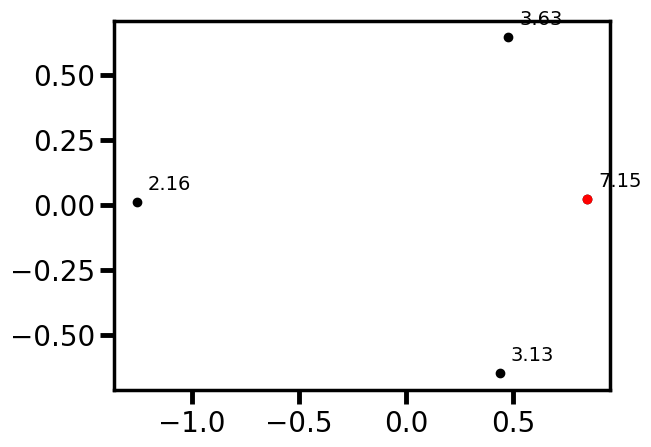

In [4]:
lens_cosmo = LensCosmo(z_lens, z_source)
cosmo = Cosmology()
e1, e2 = -0.2, -0.0
kwargs_macromodel = [{'theta_E': 1.0, 'center_x': 0.0, 'center_y': 0.0, 'e1': e1, 'e2': e2,'gamma': 2.0},
                            {'gamma1': 0.05,'gamma2':0.0}]
lens_model_list_macro = ['EPL', 'SHEAR']

lens_model_macro = LensModel(lens_model_list=lens_model_list_macro, 
                            lens_redshift_list=[z_lens]*2)
lens_model = LensModel(lens_model_list=lens_model_list_macro+lens_model_list_halos, 
                            lens_redshift_list=[z_lens]*2 + list(redshift_array_halos),
                            z_source=z_source, multi_plane=True)
source_x = -0.2
source_y = -0.
ext = LensEquationSolver(lens_model)
x_image, y_image = ext.image_position_from_source(source_x, source_y, kwargs_macromodel+kwargs_halos)
magnifications_init = np.absolute(lens_model.magnification(x_image, y_image, kwargs_macromodel+kwargs_halos))

image_index = 1 # select this image to compute the cross section 
for (xi, yi, mi) in zip(x_image, y_image, magnifications_init):
    plt.scatter(xi, yi, color='k')
    plt.annotate(str(np.round(mi, 2)), xy=(xi+0.05, yi+0.05), fontsize=14, color='k')
plt.scatter(x_image[image_index], y_image[image_index], color='r')
plt.show()

ray_interp_x, ray_interp_y = interpolate_ray_paths([1.3], 
                                                   [0.0], 
                                                   lens_model, 
                                                   kwargs_macromodel+kwargs_halos, 
                                                   z_source)

In [5]:
ext = RealizationExtensions(cdm)
pbh_mass_fraction = 0.5 # fraction of DM in PBH
logM_pbh = 6.0 # mass of PBH
mass_fraction_in_halos = 0.5 # sets the cluster/unclustered fraction
r_max_arcsec = [0.1] * len(ray_interp_x)
pbh = ext.add_primordial_black_holes(pbh_mass_fraction, 
                                     logM_pbh, 
                                     mass_fraction_in_halos, 
                                     ray_interp_x, 
                                     ray_interp_y, 
                                     r_max_arcsec, 
                                     arcsec_per_pixel=0.005, 
                                     rescale_normalizations=True)
lens_model_list_pbh, redshift_array_pbh, kwargs_halos_pbh, _ = pbh.lensing_quantities()
lens_model_pbh = LensModel(lens_model_list=lens_model_list_macro+lens_model_list_pbh, 
                            lens_redshift_list=[z_lens]*2 + list(redshift_array_pbh),
                            z_source=z_source, multi_plane=True)

In [6]:
grid_size = 2.0
npix = 200
_x = _y = np.linspace(-grid_size, grid_size, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape
kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(npix, npix)
kappa = lens_model_pbh.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel+kwargs_halos_pbh).reshape(npix, npix)

-0.06267953545115357


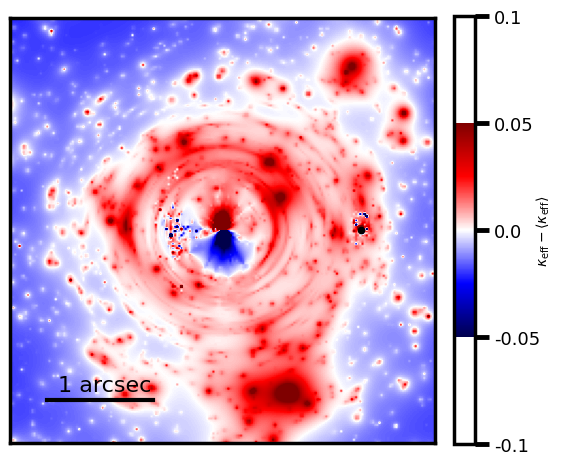

In [7]:
fig = plt.figure(1)
fig.set_size_inches(6,6)
ax = plt.subplot(111)
vminmax = 0.05
delta_kappa = kappa - kappa_macro 
print(np.mean(delta_kappa))
im = ax.imshow(delta_kappa - np.mean(delta_kappa), 
               vmin=-vminmax, vmax=vminmax, 
               cmap='seismic',
                extent=[-grid_size, grid_size, -grid_size, grid_size], 
               origin='lower')
ax.scatter(1.3, 0.0, color='k', s=20)

ax.set_xticks([])
ax.set_yticks([])
ax.plot([-1.65, -0.65],[-1.6, -1.6],color='k',lw=3)
ax.annotate('1 arcsec', fontsize=16, xy=(-1.55, -1.52))

cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_ticks([-0.1, -0.05, 0.0, 0.05, 0.1])
cbar.set_ticklabels([-0.1, -0.05, 0.0, 0.05, 0.1],fontsize=13)
cbar.set_label(r'$\kappa_{\rm{eff}} - \langle \kappa_{\rm{eff}} \rangle $',labelpad=-4)
#plt.savefig('cdm.pdf',bbox_inches='tight')
plt.show()